<a href="https://colab.research.google.com/github/calvindoro/pyschic-dream/blob/main/Statistical_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro

one sample test: statistical procedure considering the analysis of one column / feature.<br>
It can be a __percentage distribution analysis__ (categorical variable) or **mean_analysis** (continous variable)

on the other hand, 2 sample test: a statistical procedure to **compare** / calculate the __relationshop__ between 2 random variables.

## One sample test

hypothesis testing of one random variable

### one sample t-test for mean
for numerical / continuous variable

**aim**: to test that whether population's mean is different than a constant value

$$ t_stat = \frac{\bar{X} - \mu }{\frac{s}{\sqrt{n}}}$$

### one sample t-test for proportion

**aim**: used to estimate the proportion of the population<br>
for categorical variable, use one t-test for proportion to test the distribution of categories

$$ Z_calc = \frac{\hat{p} - p_0 }{\sqrt{\frac{p_0*(1-p_0)}{n}}}$$

- $ \hat{p} $: Observed probability of one certain outcome occuring
- $ p_0 $: hypothesized probability
- n: number of trials

## 2 Sample  test

2 random variables, each obtained from an independent population

- 2 continous variable
- 1 continuous & another categorical variable
- 2 categorical variable

### test between 2 continous variable

aim: __correlation__

- pearson correlation: measure the degree of relationships between __2 linearly related__ variables.<br>the value of it's coefficient ranges between [1, -1]
  - +1: positively correlated
  - -1: negatively correlated
  - 0: no correlation 
- spearman rank correlation: measure the **monotic** relationship between 2 continous random variables

### 1 continuous & 1 categorical
- T-test: to find out whether it's significant difference among categories (at most 2 groups) in terms of their continuous variables
- ANOVA: find the difference between 1 categorical (at least 3 groups or more) and another continous variable

### 2 categorical variables

- chi square test ( $ χ^2 $ )

draw comparison between 2 random categorical variables.
<br>ex: there's a difference between gender and their color preferences

# AB Test
## 1. Designing experiment
__[knowledge alert]__ want to know whether the new design perform better or worse → **two tailed test**
$$
H_0: p = p_0
$$
<br>
$$
H_a: p \neq p_0
$$
where p and $p_0$ stands for the conversion rate of new and old design respectively.<br>Noted confidence level (α = 0.05)
by which we say
<blockquote>if the probability of observing a result as extreme or more (p-value) is lower than <b>α</b>, then we reject the Null Hypothesis by 95% confidence level</blockquote>

### choosing the variables
- `control` group - old design
- `treatment` / experimental group - new design

independent variable: design to page<br>
dependent variable: conversion rate

### choosing a sample size
it's important to note that sampling over than testing the whole population (expensive and impractical), the dependent variable being measure inevitably is estimates of the true value.
<blockquote>
the <b>larger the sample size</b>, the more precise our estimates as well as smaller confidence intervals,<br>means higher chance to detect <b>difference</b> in 2 groups, if any.
</blockquote>

> how many sample should we take in each group ? 
>> Power Analysis
- power of the test (1 - β): probability of finding a statistical difference among the groups in testset when difference is really exist.
- alpha value (α) - critical value set earlier to 0.05
- effect size: how big of difference expected to be happened

In [48]:
# example of Power Analysis
import math
import scipy.stats as stats
import statsmodels.stats.api as sms

## suppose 2% improvement from 13%
effect_size = sms.proportion_effectsize(0.13, 0.15)

required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.90,# by convention however we may start with lower number, e.g. 80%
    alpha=0.05,
    ratio=1
)
required_n = math.ceil(required_n)
print(f'effect size based on initial expectation: {effect_size}\nMin Sample Size needed: {required_n}')

effect size based on initial expectation: -0.0576728617308947
Min Sample Size needed: 6319


> having set `power` parameter to 0.90 means if actual difference (around **2%** mentioned on `effect_size`) among the change of designs is really exists, we have about 90% chance to detect it as statistically significant in our test with the sample size (__6319__) we calculated

## 2. Collecting & Preparing data
- sampling

In [17]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/My Drive/Colab Notebooks/Datasets/ab_test/ab_data.zip' -d '/content/drive/My Drive/Colab Notebooks/Datasets/ab_test/' > /dev/null
!ls

Mounted at /content/drive


In [57]:
# to make sure all the control group are seeing the old page and viceversa
import os
import pandas as pd

path = '/content/drive/My Drive/Colab Notebooks/Datasets/ab_test'
df = pd.read_csv(os.path.join(path, 'ab_data.csv'))

# to remove multi-users, may use drop_duplicates instead
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'there are {multi_users} users that taken multiple times in the dataset')
users_to_drop = session_counts[session_counts > 1].index

df = df.drop_duplicates(subset=['user_id'], keep='first')
# df = df[~df.user_id.isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

control_sample = df.query('group == "control" and landing_page == "old_page"').sample(n=required_n, random_state=8)
treatment_sample = df.query('group == "treatment" and landing_page == "new_page"').sample(n=required_n, random_state=8)

ab_test = pd.concat([control_sample, treatment_sample], axis=0).reset_index(drop=True)
display(pd.crosstab(df['group'], df['landing_page']), ab_test.head(), ab_test.tail(), ab_test.info(memory_usage='deep'))

there are 3894 users that taken multiple times in the dataset
The updated dataset now has 290584 entries
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12638 entries, 0 to 12637
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       12638 non-null  int64 
 1   timestamp     12638 non-null  object
 2   group         12638 non-null  object
 3   landing_page  12638 non-null  object
 4   converted     12638 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.8 MB


landing_page,new_page,old_page
group,,
control,1006,144226
treatment,144314,1038


,user_id,timestamp,group,landing_page,converted
0,702859,2017-01-11 10:28:49.118326,control,old_page,0
1,927074,2017-01-19 01:05:49.446321,control,old_page,0
2,838452,2017-01-12 15:58:03.742645,control,old_page,0
3,657098,2017-01-19 02:48:15.668734,control,old_page,0
4,874919,2017-01-16 01:20:37.247199,control,old_page,0


,user_id,timestamp,group,landing_page,converted
12633,884578,2017-01-15 09:33:28.058171,treatment,new_page,0
12634,784276,2017-01-04 18:13:06.581739,treatment,new_page,1
12635,848573,2017-01-24 08:58:19.211431,treatment,new_page,0
12636,826514,2017-01-11 06:58:57.661438,treatment,new_page,0
12637,680116,2017-01-12 21:13:33.369246,treatment,new_page,0


None

## 3. Visualizing the results

In [58]:
import numpy as np

conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0)# standard error of the mean

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.127,0.333,0.004
treatment,0.117,0.321,0.004


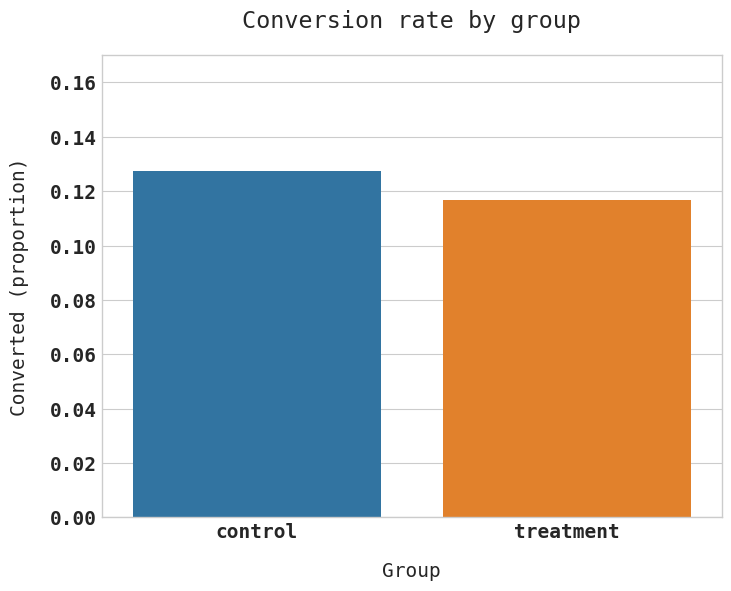

In [59]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## some plot styling preferences
# plt.style.use('seaborn-whitegrid')
font = {
    'family': 'monospace',
    'weight': 'bold',
    'size': 14
}
mpl.rc('font', **font)

plt.figure(figsize=(8, 6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], errorbar=('ci', False))

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

## 4. Hypothesis Testing

Since we have large sample (enough >> 30) and or population's deviation known<br> → use `normal approxiamation` for calculating the p-value (i.e. **z-test**)

In [60]:
from statsmodels.stats.proportion import (
    proportions_ztest, 
    proportion_confint
)

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_control = control_results.count()
n_treatment = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_control, n_treatment]

z_stat, p_val = proportions_ztest(successes, nobs=nobs)
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_val:.3f}')
print(f'ci 95% for control group: [{lower_control:.3f}, {upper_control:.3f}]')
print(f'ci 95% for treatment group: [{lower_treatment:.3f}, {upper_treatment:.3f}]')

z statistic: 1.85
p-value: 0.065
ci 95% for control group: [0.119, 0.136]
ci 95% for treatment group: [0.109, 0.125]


## 5. Drawing Conclusions

since <b>p</b>-value=0.065 is above α=0.05, hence we cannot reject null hypothesis $H_0$, which means that new design did not perform significantly different than old one. (even worse)

confidence interval of `baseline` / control group [11.9, 13.6] is much better than `treatment` [10.9, 12.5]

Continous Variable Tests
<table>
<tr><th rowspan=2>&nbsp;</th><th rowspan=2>usecase</th><th colspan=2>Distribution</th></tr>
<tr><th>Normal</th><th>Skew</th></tr>
<tr><td rowspan=4>continuous</td><td>
<li>random sample</li>
<li>within subject design</li>
</td><td>paired t-test</td><td>Wilcoxon signed-rank</td></tr>
<tr><td>
<li>between subject design</li>
<li>limited to at most 2 groups</li>
</td><td>independent t-test
<li>2 sample test</li></td><td>Mann-Whitney U-test
<li>Wilcoxon rank-sum</li></td></tr>
<tr><td>3 or more independent samples</td><td>ANOVA</td><td>Kruskal-Wallis H-test</td></tr>
<tr><td>one compared to standard</td><td>one-sample test</td><td><li>MedianAbsoluteDeviation</li><li>Wilcoxon Sign Test</li></td></tr>
</table>

## Reference
- https://towardsdatascience.com/how-to-know-which-statistical-test-to-use-for-hypothesis-testing-744c91685a5d
- https://github.com/renatofillinich/ab_test_guide_in_python/blob/master/AB%20testing%20with%20Python.ipynb
- https://towardsdatascience.com/ab-testing-with-python-e5964dd66143
- https://www.ctc.ucl.ac.uk/TrainingDocuments/Uploaded/Day%204%20-%20Multiple%20groups%20and%20comparisons_03112017_C26s5.pdf
- https://www.statology.org/paired-samples-t-test/
- https://statisticsbyjim.com/hypothesis-testing/paired-t-test/
- https://docs.juliahub.com/Pingouin/Lh7T4/0.2.0/nonparametric/
- https://sixsigmastudyguide.com/1-sample-wilcoxon-non-parametric-hypothesis-test/